# Importing libraries and simulating data
This cell imports the required libraries and defines a function to simulate data for the Difference-in-Differences (DiD) analysis, generating two datasets: one with parallel trends and one with a violation of parallel trends.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

np.random.seed(42)

def simulate_did_data(parallel_trends=True):
    years = list(range(2011, 2022))
    cities = ['City A', 'City B']
    data = []

    for city in cities:
        for year in years:
            for _ in range(50):
                base = 10
                trend = -0.3 * (year - 2011)  # macroeconomic trend
                city_effect = -1 if city == 'City B' else 0

                # Violation of parallel trends
                if not parallel_trends and city == 'City A':
                    trend += -0.3 * (year - 2011)

                # Treatment starts
                treatment_effect = -1 if (city == 'City A' and year >= 2017) else 0
                noise = np.random.normal(0, 1)
                unemployment = base + trend + city_effect + treatment_effect + noise

                data.append({
                    'city': city,
                    'year': year,
                    'unemployment': unemployment
                })

    df = pd.DataFrame(data)
    df['post'] = (df['year'] >= 2017).astype(int)
    df['treated'] = (df['city'] == 'City A').astype(int)
    df['did'] = df['post'] * df['treated']
    return df

df_parallel = simulate_did_data(parallel_trends=True)
df_violation = simulate_did_data(parallel_trends=False)







# OLS Regression: Parallel Trends Scenario
This cell fits an OLS regression model to the simulated data with parallel trends to estimate the treatment effect using the Difference-in-Differences (DiD) approach.

In [ ]:
model_parallel = smf.ols('unemployment ~ treated + post + did', data=df_parallel).fit()

print(model_parallel.summary())


                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     381.5
Date:                Tue, 10 Jun 2025   Prob (F-statistic):          1.26e-169
Time:                        21:12:09   Log-Likelihood:                -1651.3
No. Observations:                1100   AIC:                             3311.
Df Residuals:                    1096   BIC:                             3331.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2809      0.063    131.869      0.0

# OLS Regression: Violation of Parallel Trends Scenario
This cell fits an OLS regression model to the simulated data where the parallel trends assumption is violated, to illustrate the impact on the estimated treatment effect.

In [ ]:
model_violation = smf.ols('unemployment ~ treated + post + did', data=df_violation).fit()

print(model_violation.summary())

                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     618.4
Date:                Tue, 10 Jun 2025   Prob (F-statistic):          3.74e-235
Time:                        21:12:09   Log-Likelihood:                -1831.8
No. Observations:                1100   AIC:                             3672.
Df Residuals:                    1096   BIC:                             3692.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2772      0.074    111.859      0.0

# Plotting the DiD Results
This cell defines a function to plot the average unemployment rates for each city over time and visualizes the effect of treatment under both parallel trends and violation scenarios.

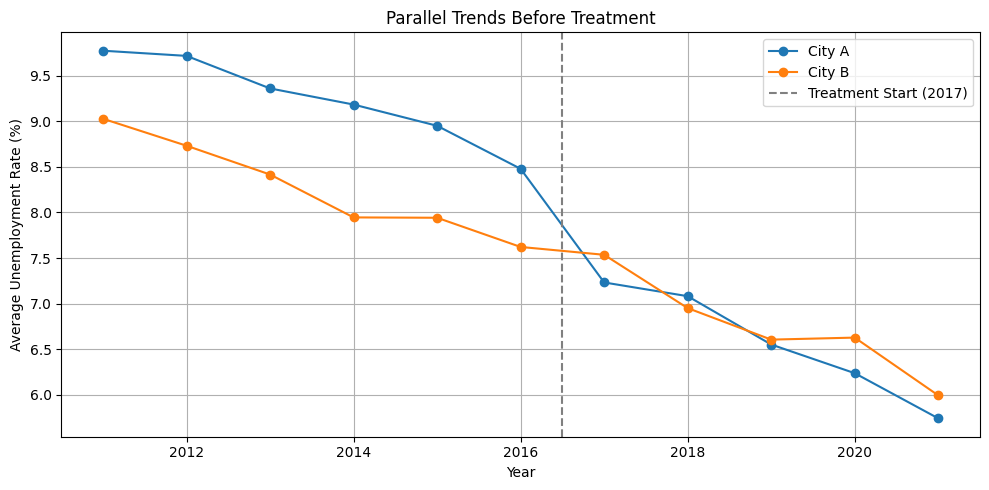

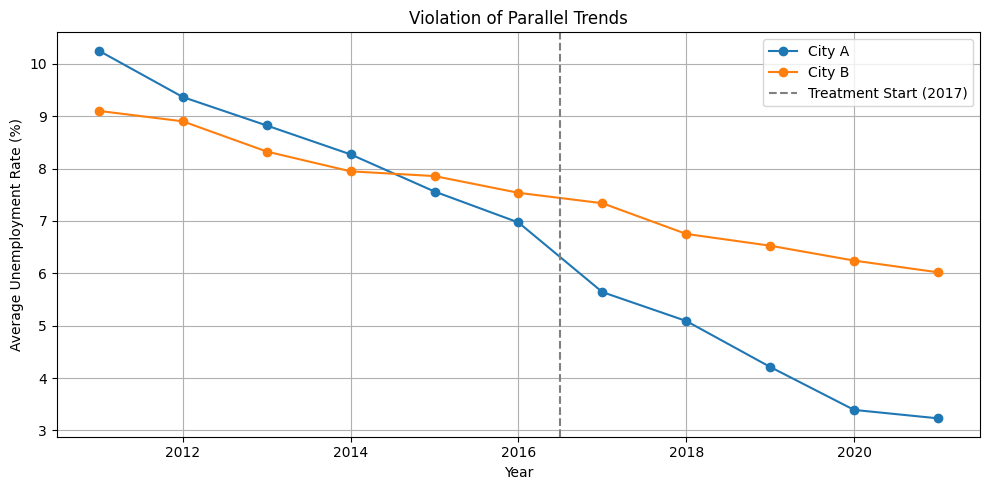

In [ ]:
# Plotting function
def plot_did_results(df, title):
    avg_df = df.groupby(['city', 'year'])['unemployment'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    for city in avg_df['city'].unique():
        group = avg_df[avg_df['city'] == city]
        plt.plot(group['year'], group['unemployment'], marker='o', label=city)

    plt.axvline(2016.5, color='gray', linestyle='--', label='Treatment Start (2017)')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Average Unemployment Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot both scenarios
plot_did_results(df_parallel, "Parallel Trends Before Treatment")
plot_did_results(df_violation, "Violation of Parallel Trends")

# Pre-test for Parallel Trends
This cell filters the data to pre-treatment years and prepares for a pre-trend test to check the parallel trends assumption in both scenarios.

Pre-test

In [ ]:


# Assume df_parallel and df_violation have already been generated using our earlier code

# Filter pre-treatment data (years before 2017)
pre_df_parallel = df_parallel[df_parallel['year'] < 2017]
pre_df_violation = df_violation[df_violation['year'] < 2017]


# Pre-trend Test Regression
This cell fits OLS regression models to the pre-treatment data for both scenarios to formally test the parallel trends assumption.

In [ ]:
# Scenario 1: Parallel Trends
model_pre_parallel = smf.ols('unemployment ~ treated * year', data=pre_df_parallel).fit()
print("Scenario 1 - Pre-trend test results:")
print(model_pre_parallel.summary())

# Scenario 2: Parallel Trends Violated
model_pre_violation = smf.ols('unemployment ~ treated * year', data=pre_df_violation).fit()
print("\nScenario 2 - Pre-trend test results:")
print(model_pre_violation.summary())




Scenario 1 - Pre-trend test results:
                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     91.29
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.28e-48
Time:                        21:29:33   Log-Likelihood:                -840.81
No. Observations:                 600   AIC:                             1690.
Df Residuals:                     596   BIC:                             1707.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept  

# Placebo Test
This cell creates placebo treatment variables by assigning an earlier treatment year and prepares the data for placebo regression analysis.

Placebo test

In [ ]:

## Copy the original dataset
df_placebo_parallel = df_parallel.copy()
df_placebo_violation = df_violation.copy()

## Set placebo treatment to start earlier (2014)
df_placebo_parallel['placebo_post'] = (df_placebo_parallel['year'] >= 2014).astype(int)
df_placebo_parallel['placebo_did'] = df_placebo_parallel['treated'] * df_placebo_parallel['placebo_post']

df_placebo_violation['placebo_post'] = (df_placebo_violation['year'] >= 2014).astype(int)
df_placebo_violation['placebo_did'] = df_placebo_violation['treated'] * df_placebo_violation['placebo_post']


# Placebo Regression Analysis
This cell fits OLS regression models to the placebo datasets to check for spurious treatment effects before the actual treatment year.

In [ ]:
##  Scenario 1 (Parallel Trends)
placebo_model_parallel = smf.ols('unemployment ~ treated + placebo_post + placebo_did',
                                 data=df_placebo_parallel[df_placebo_parallel['year'] < 2017]).fit()
print("Scenario 1 (Parallel Trends) - Placebo test results:")
print(placebo_model_parallel.summary())

##  Scenario 2 (Parallel Trends Violated)
placebo_model_violation = smf.ols('unemployment ~ treated + placebo_post + placebo_did',
                                  data=df_placebo_violation[df_placebo_violation['year'] < 2017]).fit()
print("\nScenario 2 (Parallel Trends Violated) - Placebo test results:")
print(placebo_model_violation.summary())


Scenario 1 (Parallel Trends) - Placebo test results:
                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     78.90
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           5.46e-43
Time:                        21:43:55   Log-Likelihood:                -853.91
No. Observations:                 600   AIC:                             1716.
Df Residuals:                     596   BIC:                             1733.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------


Scenario 2 (Parallel Trends Violated) - Placebo test results:
                            OLS Regression Results                            
Dep. Variable:           unemployment   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     100.1
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.83e-52
Time:                        21:43:51   Log-Likelihood:                -894.88
No. Observations:                 600   AIC:                             1798.
Df Residuals:                     596   BIC:                             1815.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------